# Table of Contents
* [Introduction](#Introduction)
	* [Guiding questions](#Guiding-questions)
	* [Related notebooks](#Related-notebooks)
* [Setup](#Setup)
	* [Imports](#Imports)
	* [Load data](#Load-data)
	* [code](#code)
	* [load](#load)
* [Analysis](#Analysis)
	* [code](#code)
	* [run](#run)
* [Conclusions](#Conclusions)
	* [Key findings](#Key-findings)
	* [Next steps](#Next-steps)


# Introduction

## Guiding questions

* Guiding question:
Can I improve grid extraction by finding largest component first, then extracting contours

## Related notebooks

* **Related notebooks:**  early_table_parse_experiment.ipynb

# Setup

## Imports

In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
import hashlib
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [3]:
import os
import cv2

import PIL.Image as Image
import skimage.filters

from urllib.request import url2pathname

In [4]:
%load_ext version_information
%reload_ext version_information
%version_information numpy, matplotlib, pandas, scipy, cv2, skimage, PIL

Software,Version
Python,3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
IPython,6.0.0
OS,Darwin 16.6.0 x86_64 i386 64bit
numpy,1.12.1
matplotlib,2.0.2
pandas,0.20.1
scipy,0.19.0
cv2,3.2.0
skimage,0.13.0
PIL,4.1.1


# Analysis

## code

In [5]:
def ifa(img_arr):
    return Image.fromarray(img_arr)


def ifb(blobs):
    plt.imshow(blobs, cmap='nipy_spectral')
    _ = plt.axis('off')

    
def random_color():
    import random
    return random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)


def draw_detections(img_path, found_cells):    
    image = cv2.imread(img_path)
    color_counter = 0
    for cell in found_cells:
        start_x = cell[0][0]
        start_y = cell[0][1]
        end_x = cell[1][0]
        end_y = cell[1][1]
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), color=random_color(), thickness=2)
        color_counter += 1
    return Image.fromarray(image)

In [6]:
# %%time
# for image_to_do in test_images[97:]:
#     test_img = cv2.imread(image_to_do)
#     image_name = os.path.split(image_to_do)[-1]

#     foreground_img = foreground_image(test_img)
#     connected_components = connect_and_label_components(foreground_img)
#     candidate_grid = find_largest_component(connected_components)
#     grid_contours = compute_grid_contours(candidate_grid)

#     bounding_boxes = [cell_from_contour(cont) for cont in grid_contours]

#     cv2.imwrite(os.path.join(output_dir, image_name), test_img)
#     cv2.imwrite(os.path.join(output_dir, image_name.replace('.png', '_grid.png')), candidate_grid)
#     draw_detections(image_to_do, bounding_boxes).save(os.path.join(output_dir,image_name.replace('.png', '_cells.png')))

## run

In [7]:
from ai2.vision.tableparse.detect_grid import foreground_image
from ai2.vision.tableparse.detect_grid import connect_and_label_components
from ai2.vision.tableparse.detect_grid import find_largest_component
from ai2.vision.tableparse.detect_grid import compute_grid_contours
from ai2.vision.tableparse.detect_grid import cell_from_contour
from ai2.vision.tableparse.img_utils import ifa

from ai2.vision.tableparse.cell import GridCell

In [8]:
import glob
hard_image = '/Users/schwenk/wrk/tableparse/data/tricky_tables/unnamed-3.png'
another_image = '/Users/schwenk/wrk/tableparse/data/tricky_tables/unnamed-2.png'
easy_image = '/Users/schwenk/wrk/tableparse/vision-tableparse/examples/sight-word-bingo.png'

output_dir = 'test_cc_output'
test_images = glob.glob('/Users/schwenk/wrk/tableparse/data/test_data/images/*')

In [9]:
image_to_do = test_images[110]

image_to_do

'/Users/schwenk/wrk/tableparse/data/test_data/images/table_111.png'

In [13]:
# image_to_do = '/Users/schwenk/wrk/tableparse/data/tricky_tables/unnamed-1.png'
image_to_do = '/Users/schwenk/wrk/tableparse/data/test_data/images/table_002.png'

In [14]:
test_img = cv2.imread(image_to_do)
image_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
foreground_img = foreground_image(image_gray)
connected_components = connect_and_label_components(foreground_img)
candidate_grid = find_largest_component(connected_components)
grid_contours = compute_grid_contours(candidate_grid)
grid_cells = [GridCell(cell_from_contour(cont)) for cont in grid_contours]
bounding_boxes = [cell_from_contour(cont) for cont in grid_contours]

next and previous contours at the same hierarchical level, the first child contour and the parent contour

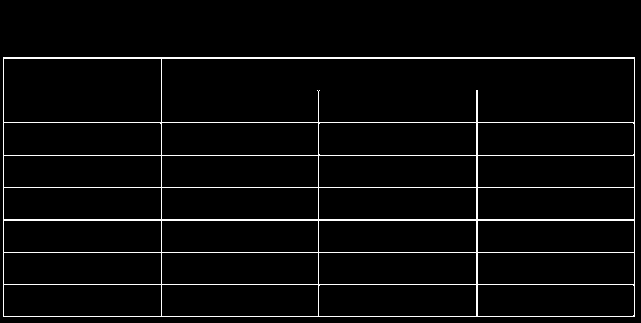

In [15]:
ifa(candidate_grid)

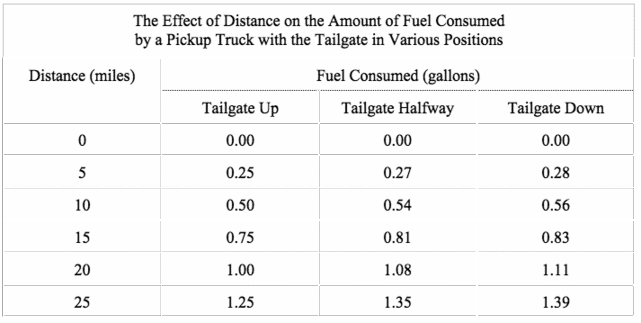

In [16]:
ifa(cv2.add(image_gray, candidate_grid))

In [133]:
agc = pd.Series((candidate_grid + timg).flatten()).value_counts()
agc[agc.index.isin([31, 255])]

255    505087
31      13564
dtype: int64

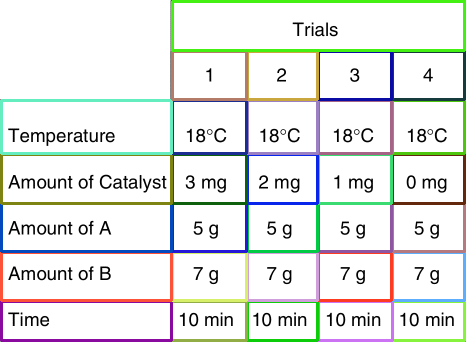

In [83]:
draw_detections(image_to_do, bounding_boxes)

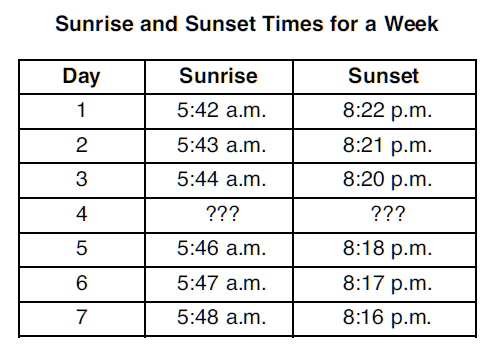

In [726]:
ifa(test_img)

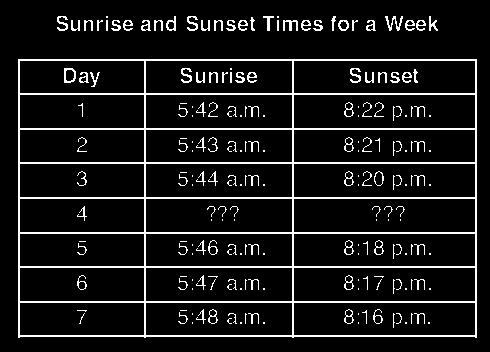

In [727]:
ifa(foreground_img)

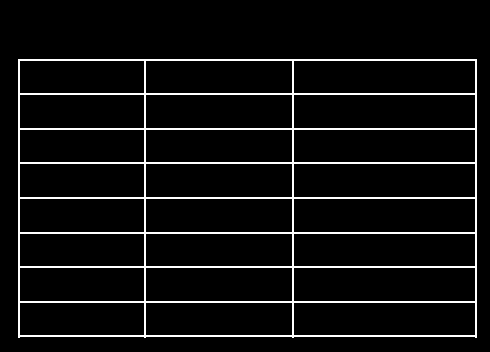

In [728]:
ifa(candidate_grid)

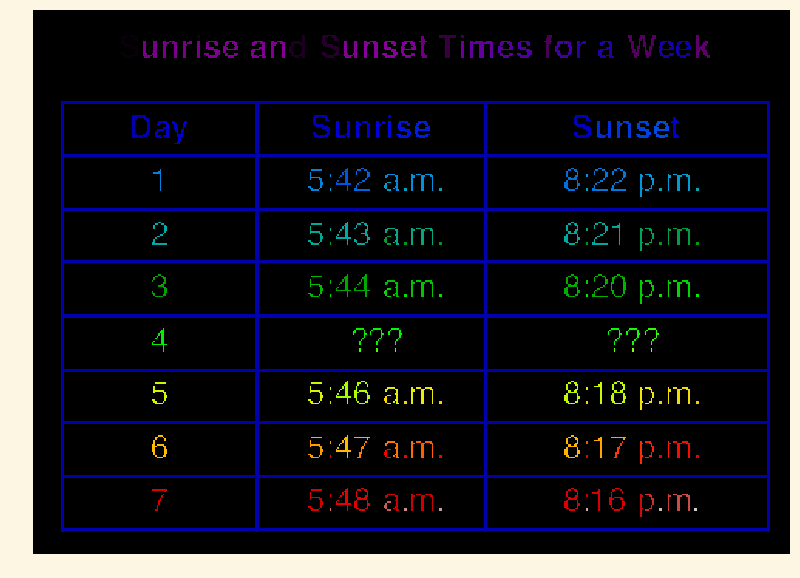

In [729]:
ifb(connected_components)

# match to OCR

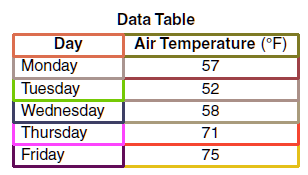

In [1051]:
image_to_do = test_images[97]

test_img = cv2.imread(image_to_do)
image_name = os.path.split(image_to_do)[-1]

foreground_img = foreground_image(test_img)
connected_components = connect_and_label_components(foreground_img)
candidate_grid = find_largest_component(connected_components)
grid_contours = compute_grid_contours(candidate_grid)

bounding_boxes = [cell_from_contour(cont) for cont in grid_contours]
draw_detections(image_to_do, bounding_boxes)

In [190]:
np.argwhere(candidate_grid)

array([[556,  42],
       [556,  43],
       [556, 225],
       ..., 
       [783, 674],
       [783, 675],
       [783, 676]])

In [800]:
test_ocr_img =cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY) + candidate_grid

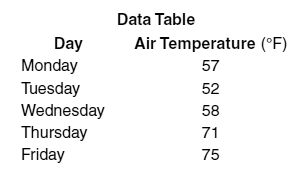

In [801]:
ifa(test_ocr_img)

In [802]:
img_buffer = BytesIO()

In [803]:
ifa(test_ocr_img).save(img_buffer, format="PNG")
img_str = base64.b64encode(img_buffer.getvalue())

In [1108]:
img_str = base64.b64encode(cv2.imencode('.png', test_ocr_img)[1].tostring())

In [1109]:
import base64
from io import BytesIO
import requests

In [1110]:
api_entry_point = 'http://vision-ocr.dev.allenai.org/v1/ocr'
b64_encoded_image = base64.b64encode(test_ocr_img.tostring())
header = {'Content-Type': 'application/json'}
request_data = {
    'image': img_str.decode('utf-8'),
    'mergeBoxes': False,
    'includeMergedComponents': True
}

json_data = json.dumps(request_data)
response = requests.post(api_entry_point, data=json_data, headers=header)
print(response.reason)
json_response = json.loads(response.content.decode())

OK


In [807]:
def query_vision_ocr(image_url, merge_boxes=False, include_merged_components=False, as_json=True):
    b64_encoded_image = base64.b64encode(test_ocr_img)
    api_entry_point = 'http://vision-ocr.dev.allenai.org/v1/ocr'
    b64_encoded_image = base64.b64encode(test_ocr_img)

    header = {'Content-Type': 'application/json'}
    request_data = {
        'image': base_64_img,
        'mergeBoxes': merge_boxes,
        'includeMergedComponents': include_merged_components
    }

    json_data = json.dumps(request_data)
    response = requests.post(api_entry_point, data=json_data, headers=header)
    print(response.reason)
    json_response = json.loads(response.content.decode())
    if as_json:
        response = json_response
    return response

In [62]:
def draw_detections_w_text(img_path, grid_cells):    
    image = cv2.imread(img_path)
    color_counter = 0
    for cell in grid_cells:
        cv2.rectangle(image, (cell.l_x(), cell.l_y()), (cell.u_x(), cell.u_y()), color=random_color(), thickness=2)
        cv2.putText(image, cell.text(), (cell.l_x(), cell.u_y()), cv2.FONT_HERSHEY_PLAIN, 0.8, (0,0,255), 2)
        color_counter += 1
    return Image.fromarray(image)

In [64]:
grid_cells = [GridCell(cell) for cell in bounding_boxes]

In [1096]:
matches = assign_ocr_to_cells(ocr_detections, grid_cells)

In [1097]:
matches

In [1098]:
ocr_detections

[Data Table, 195, 118, 26, 13,
 Day, 84, 54, 53, 37,
 Air Temperature (OF), 287, 134, 53, 37,
 Monday, 78, 21, 76, 56,
 57, 220, 202, 72, 60,
 Tuesday, 81, 21, 99, 81,
 52, 220, 202, 96, 82,
 Wednesday, 105, 21, 120, 104,
 58, 220, 201, 118, 104,
 Thursday, 87, 21, 142, 125,
 71, 218, 201, 140, 126,
 Friday, 65, 22, 165, 146,
 75, 221, 202, 162, 147]

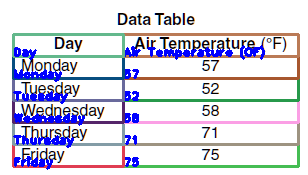

In [1103]:
draw_detections_w_text(image_to_do, grid_cells)

In [1104]:
grid_cells

[75, 298, 123, 166, 144,
 Friday, 123, 13, 166, 144,
 71, 298, 123, 144, 122,
 Thursday, 123, 13, 144, 122,
 58, 298, 123, 122, 100,
 Wednesday, 123, 13, 122, 100,
 52, 298, 123, 100, 78,
 Tuesday, 123, 13, 100, 78,
 57, 298, 123, 78, 56,
 Monday, 123, 13, 78, 56,
 Air Temperature (OF), 298, 123, 56, 34,
 Day, 123, 13, 56, 34]

# Conclusions

Using connected components to find the grid is promising. It should work for nearly all Aristo Tables